In [1]:
import pandas as pd

import xgboost as xgb

import seaborn as sns

import optuna

from sklearn.metrics import r2_score

#### Load data

In [2]:
X_train = pd.read_csv("train_embeddings.csv")
X_test = pd.read_csv("test_embeddings.csv")
Y_train = pd.read_csv("../../data/ld50/train.csv")[["ld50"]]
Y_test = pd.read_csv("../../data/ld50/test.csv")[["ld50"]]

dtrain = xgb.DMatrix(X_train, Y_train)
dtest = xgb.DMatrix(X_test, Y_test)

<Axes: >

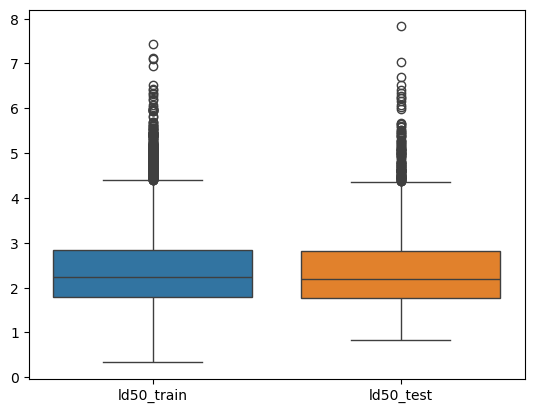

In [3]:
plot_df = Y_train.join(Y_test, lsuffix="_train", rsuffix="_test")
sns.boxplot(plot_df)

#### Train

In [4]:
best_model = None
curr_model = None

def objective(trial):
    param = {
        'verbosity': 1,
        'max_depth': trial.suggest_int('max_depth', 3, 8), 
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 5e-1), 
        'objective': trial.suggest_categorical("objective", ['reg:squarederror', 'reg:absoluteerror', 'reg:squaredlogerror']),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0)
    }

    num_rounds = trial.suggest_int('num_rounds', 1000, 5000, log=True)
    bst = xgb.train(param, dtrain, num_rounds)
    trial.set_user_attr(key="best_model", value=bst)

    y = bst.predict(dtest)
    return r2_score(Y_test, y)

def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_model", value=trial.user_attrs["best_model"])


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, callbacks=[callback])
bst = study.user_attrs["best_model"]

[I 2024-06-14 09:26:06,392] A new study created in memory with name: no-name-035ecf17-2cd2-4cd0-aca7-2bf3041bd76f
[I 2024-06-14 09:26:14,859] Trial 0 finished with value: 0.44905212000939265 and parameters: {'max_depth': 3, 'learning_rate': 0.3700533536180124, 'objective': 'reg:squarederror', 'lambda': 6.91932991726232, 'alpha': 9.58330717241916, 'num_rounds': 1326}. Best is trial 0 with value: 0.44905212000939265.
[I 2024-06-14 09:26:22,265] Trial 1 finished with value: 0.30907588292426735 and parameters: {'max_depth': 6, 'learning_rate': 0.10185910643560718, 'objective': 'reg:squaredlogerror', 'lambda': 3.838016547702588, 'alpha': 9.98636880186699, 'num_rounds': 1827}. Best is trial 0 with value: 0.44905212000939265.
[I 2024-06-14 09:26:33,938] Trial 2 finished with value: 0.42365197251207143 and parameters: {'max_depth': 7, 'learning_rate': 0.07972051031407479, 'objective': 'reg:squaredlogerror', 'lambda': 7.069233392117429, 'alpha': 3.6171206642470084, 'num_rounds': 1563}. Best is 

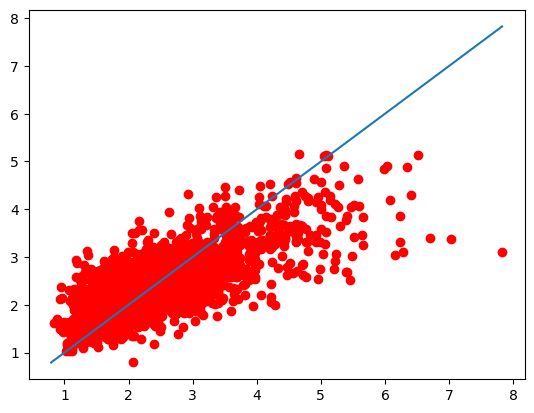

In [8]:
y = bst.predict(dtest)
import matplotlib.pyplot as plt
max_val = max(y.max(), Y_test.max()[0])
min_val = min(y.min(), Y_test.min()[0])
plt.plot([min_val, max_val], [min_val, max_val])
plt.scatter(Y_test, y, color='r')

In [9]:
from datetime import datetime
bst.save_model(f"xgboost_model_{datetime.now().isoformat()}.json")